In [26]:
%matplotlib inline

import math

import numpy as np
import statsmodels.api as sm
import scipy.spatial.distance as ssd
import scipy.stats as ss
import matplotlib.pyplot as plt
import time
import random
from scipy.stats import norm

import csv
import pandas as pd
import Ipynb_importer
from Bayesian_Decoder import fit, BayesianDecoder, MemorylessDecoder, Position_basedDecoder, Loc_trainsitionDecoder
from HSE_detector import HSE_detection

# Data Processing

load data

In [3]:
position = np.load('Position.npy', allow_pickle=True)  # [20, [one trial]] 
bins = position[0].shape[0]
speed = np.load('Speed.npy', allow_pickle=True)
triggers = np.load('Triggers.npy')
trains = pd.read_csv('Trains.csv')

In [85]:
triggers

array([2344.93356667, 2502.48096667, 2671.4631    , 2963.07323333,
       3117.59473333, 3322.06823333, 3741.86146667, 3832.79463333,
       3910.31106667, 4022.00846667, 4355.38046667, 4539.95273333,
       4673.33926667, 4768.73903333, 4803.84223333, 4934.25496667,
       5125.06216667, 5230.585     , 5316.8356    , 5862.76433333,
       5984.9803    ])

initializing parameters

In [4]:
cell_num = 43
bins = 100  # 30000
trial_num = 20

change Trains.csv into list

In [5]:
%%time
spike_trains = [[] for i in range(cell_num)]
for cell in range(cell_num):
    for i in range(trains.shape[1]):
        if trains.iloc[cell, i]:
            spike_trains[cell].append(trains.iloc[cell, i])

Wall time: 46.9 s


calculating bin number for each trial, according to bin size

In [6]:
triggers_nBins = np.zeros(20)
for i in range(20):
    triggers_nBins[i] = round((triggers[i+1] - triggers[i]) * bins, 0)
print(triggers_nBins)

[15755. 16898. 29161. 15452. 20447. 41979.  9093.  7752. 11170. 33337.
 18457. 13339.  9540.  3510. 13041. 19081. 10552.  8625. 54593. 12222.]


change position and speed into right bin size

In [7]:
%%time
triggers_nBins = triggers_nBins.astype('int')
pos = [np.zeros(triggers_nBins[j]) for j in range(trial_num)]
spe = [np.zeros(triggers_nBins[j]) for j in range(trial_num)]
for trial in range(trial_num):
    for i in range(triggers_nBins[trial]):
        if i == triggers_nBins[trial]-1:
            pos[trial][i] = np.mean(position[trial][i*int(30000/bins):])
            spe[trial][i] = np.mean(speed[trial][i*int(30000/bins):])
        else:
            pos[trial][i] = np.mean(position[trial][i*int(30000/bins): (i+1)*int(30000/bins)])
            spe[trial][i] = np.mean(speed[trial][i*int(30000/bins): (i+1)*int(30000/bins)])

Wall time: 9.64 s


## findout pre-trains, post-trains and trial-trains

In [8]:
# add in firing_rate
# calculate pre and post trains
pre_trains = [[] for i in range(cell_num)]
post_trains = [[] for i in range(cell_num)]
trial_trains = [np.zeros((cell_num, int(triggers_nBins[j]))) for j in range(trial_num)]

In [9]:
%%time
pointers = np.zeros(cell_num)
for trial in range(trial_num+1):
    if trial != trial_num:
        trial_Bins = int(triggers_nBins[trial])
    for cell in range(cell_num):
        pointer = int(pointers[cell])
        if trial == 0:
            trial_spike = []
            while pointer < len(spike_trains[cell]):
                if spike_trains[cell][pointer] < triggers[trial]:
                    pre_trains[cell].append(spike_trains[cell][pointer])
                    pointer += 1
                elif spike_trains[cell][pointer] < triggers[trial+1]:
                    trial_spike.append(spike_trains[cell][pointer])
                    pointer += 1
                else:
                    break
            trial_spike = np.array(trial_spike)
            cell_rate = np.zeros(trial_Bins)
            trial_spike = np.round((trial_spike - triggers[trial])*bins, 0)
            for item in trial_spike:
                if int(item) == trial_Bins:
                    pointer -= 1
                else:
                    cell_rate[int(item)] += 1
            trial_trains[trial][cell, :] = cell_rate * bins
            pointers[cell] = pointer
        elif trial == trial_num:
            if pointer < len(spike_trains[cell]):
                post_trains[cell] = spike_trains[cell][pointer:]
        else:
            trial_spike = []
            while pointer < len(spike_trains[cell]):
                if spike_trains[cell][pointer] < triggers[trial+1]:
                    trial_spike.append(spike_trains[cell][pointer])
                    pointer += 1
                else:
                    break
            trial_spike = np.array(trial_spike)
            cell_rate = np.zeros(trial_Bins)
            trial_spike = np.round((trial_spike - triggers[trial])*bins, 0)
            for item in trial_spike:
                if int(item) == trial_Bins:
                    pointer -= 1
                else:
                    cell_rate[int(item)] += 1
            trial_trains[trial][cell, :] = cell_rate * bins
            pointers[cell] = pointer

Wall time: 576 ms


In [79]:
# delete nan in post_Bins
post_trains_re = [[] for i in range(cell_num)]
for i in range(cell_num):
    for j in range(len(post_trains[i])):
        if not np.isnan(post_trains[i][j]):
            post_trains_re[i].append(post_trains[i][j])

In [107]:
pre_Bins = int(math.ceil(triggers[0] * bins))
biggest_t = 0
for i in range(cell_num):
    try:
        t = np.max(post_trains_re[i])
    except:
        continue
    if t > biggest_t:
        biggest_t = t
post_Bins = int(math.ceil((biggest_t-triggers[-1])*bins))
pre_Bins, post_Bins

(234494, 230411)

In [119]:
# arange pre and post trains into bins
pre_cell_trains = np.zeros((cell_num, pre_Bins))
for cell in range(cell_num):
    for i in range(len(pre_trains[cell])):
        pre_cell_trains[cell][int(math.ceil(pre_trains[cell][i]*bins))] += 1
post_cell_trains = np.zeros((cell_num, post_Bins))
for cell in range(cell_num):
    for i in range(len(post_trains_re[cell])):
        post_cell_trains[cell][int((post_trains_re[cell][i]-triggers[-1])*bins)] += 1
pre_cell_trains = pre_cell_trains * bins
post_cell_trains = post_cell_trains * bins

## findout running periods and non-run periods

In [10]:
run_trains = [[] for i in range(cell_num)]
nonrun_trains = [[] for i in range(cell_num)]

In [11]:
%%time
cell_run = [[] for i in range(cell_num)]
cell_nonrun = [[] for i in range(cell_num)]
pos_run = []
pos_nonrun = []
for trial in range(trial_num):
    for i in range(spe[trial].shape[0]):
        if spe[trial][i] > 2:
            for cell in range(cell_num):
                cell_run[cell].append(trial_trains[trial][cell, i])
            pos_run.append(pos[trial][i])
        else:
            for cell in range(cell_num):
                cell_nonrun[cell].append(trial_trains[trial][cell, i])
            pos_nonrun.append(pos[trial][i])
cell_run = np.array(cell_run)
cell_nonrun = np.array(cell_nonrun)
pos_run = np.array(pos_run)
pos_nonrun = np.array(pos_nonrun)

Wall time: 9.39 s


arrange cell spikes into 500ms windows as osniell

In [12]:
%%time
win = 25
Bins = int(cell_run.shape[1] // win)
cell_run_win = np.zeros((cell_num, Bins))
pos_run_win = np.zeros(Bins)
for i in range(Bins):
    for cell in range(cell_num):
        cell_run_win[cell, i] = np.mean(cell_run[cell, i*win:(i+2)*win])
    pos_run_win[i] = np.mean(pos_run[i*win:(i+2)*win])

Wall time: 2.53 s


move away cell that does not spike in running periods

In [13]:
for i in range(cell_num):
    print(np.max(cell_run_win[i]), end=';')

4.0;4.0;50.0;44.0;4.0;20.0;2.0;22.0;0.0;104.0;22.0;10.0;10.0;10.0;12.0;8.0;42.0;44.0;8.0;50.0;0.0;102.0;20.0;8.0;48.0;18.0;50.0;104.0;24.0;0.0;22.0;6.0;16.0;48.0;110.0;34.0;24.0;4.0;4.0;0.0;26.0;10.0;14.0;

In [14]:
cell_run_num = cell_num - 4
cell_run_win_re = np.zeros((cell_run_num, cell_run_win.shape[1]))
j = 0
for i in range(cell_num):
    if i in [8, 20, 29, 39]:
        continue
    cell_run_win_re[j,:] = cell_run_win[i, :]
    j += 1

In [15]:
for i in range(cell_run_num):
    print(np.max(cell_run_win_re[i]), end=';')

4.0;4.0;50.0;44.0;4.0;20.0;2.0;22.0;104.0;22.0;10.0;10.0;10.0;12.0;8.0;42.0;44.0;8.0;50.0;102.0;20.0;8.0;48.0;18.0;50.0;104.0;24.0;22.0;6.0;16.0;48.0;110.0;34.0;24.0;4.0;4.0;26.0;10.0;14.0;

# fit tunning curve

In [34]:
# position
track_begin = 600
track_end = 2000
track_len = track_end - track_begin
track_sample_len = 2
pos_run_win = pos_run_win - track_begin

fit_time:  0.5630412101745605


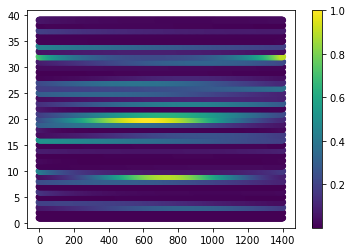

Wall time: 1.8 s


In [17]:
%%time
tuning, loc_possi, loc_prob = fit(cell_run_win_re, pos_run_win, track_len, 2, int(track_len/track_sample_len)+1, cell_run_num)

test fitting results

In [160]:
tuning

array([[0.03947738, 0.03880855, 0.03815284, ..., 0.02185203, 0.02219203,
        0.02253836],
       [0.02569715, 0.02575393, 0.0258106 , ..., 0.01434987, 0.01429423,
        0.01423868],
       [0.61610027, 0.62069311, 0.62530947, ..., 1.69992271, 1.69222918,
        1.6845416 ],
       ...,
       [1.88245536, 1.87764029, 1.87284388, ..., 0.7174652 , 0.71732216,
        0.71718157],
       [0.07102093, 0.07137612, 0.07173174, ..., 0.02331945, 0.02312904,
        0.02293976],
       [0.58979538, 0.58594415, 0.58212712, ..., 0.26665807, 0.26780508,
        0.2689612 ]])

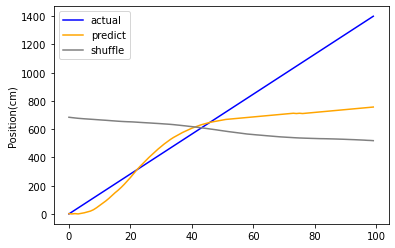

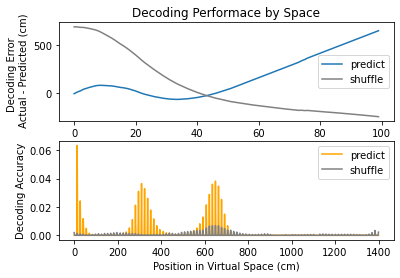

In [158]:
# perfect events
time_Bins = 100
dtime = 0.001
cell_activity_test = np.zeros((cell_run_num, time_Bins))
cell_activity_test_r = np.zeros((cell_run_num, time_Bins))
position_test = np.linspace(0, track_len, time_Bins)
position_test_r = np.linspace(track_len, 0, time_Bins)
for i in range(cell_run_num):
    for t in range(time_Bins):
        cell_activity_test[i][t] = 1 / dtime * tuning[i][int(position_test[t] / track_sample_len)]
        cell_activity_test_r[i][t] = 1 / dtime * tuning[i][int(position_test_r[t] / track_sample_len)]
LD = Loc_trainsitionDecoder(dtime, track_len, track_sample_len, track_Bins, cell_run_num, tuning, loc_prob=loc_prob)
LD.test(cell_activity_test, position_test)

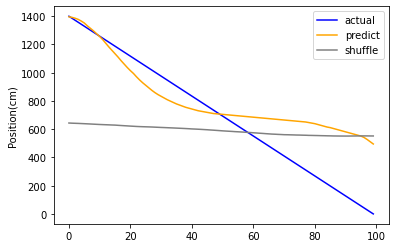

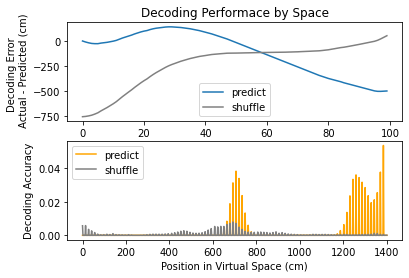

In [159]:
LD.test(cell_activity_test_r, position_test_r)

rearrange the rank of the cell and plot

In [18]:
cell_rank = np.argmax(tuning, axis=1)
cell_rank

array([  0, 253, 434,  79, 413,   0, 286, 228, 376,   0, 544,   0, 451,
       700, 470,   0, 491,   0, 194, 318, 371,   0, 440, 542, 176, 700,
       282, 431, 393,  51, 464, 700, 318,   0,   0, 700,   0, 265,   0],
      dtype=int64)

In [19]:
sorted_ID = np.argsort(cell_rank)
sorted_ID

array([ 0, 36, 34, 33, 21, 17, 15, 11,  9, 38,  5, 29,  3, 24, 18,  7,  1,
       37, 26,  6, 32, 19, 20,  8, 28,  4, 27,  2, 22, 12, 30, 14, 16, 23,
       10, 31, 13, 25, 35], dtype=int64)

In [2]:
track_len = 1400
track_Bins = int(track_len/2)+1
loc_range = np.linspace(0, track_len, track_Bins)
xs = np.zeros((cell_run_num, track_Bins))
ys = np.zeros((cell_run_num, track_Bins))
zs = np.zeros((cell_run_num, track_Bins))
for i in range(cell_run_num):
    zs[i, :] = tuning[sorted_ID[i]].copy()
    xs[i, :] = loc_range.copy()
    ys[i, :] = [i + 1 for n in range(track_Bins)]
xs = xs.flatten()
ys = ys.flatten()
zs = zs.flatten()
for cell in range(cell_run_num):
    zs[cell] = zs[cell] / np.sum(zs[cell])
plt.scatter(xs, ys, c=zs)
plt.colorbar()
plt.show()

NameError: name 'np' is not defined

# detect HSE events

## in nonrunning periods

In [114]:
%%time
nonrun_mean, nonrun_SD, nonrun_syn_spike_rate, nonrun_HSE_events_time = HSE_detection(cell_nonrun, ori_bins=100)
# should I exclude cells that are not firing in the running periods?

Wall time: 1.8 s


draw plots to show HSE events

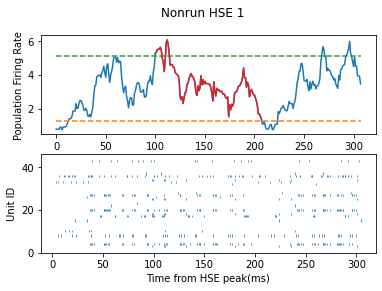

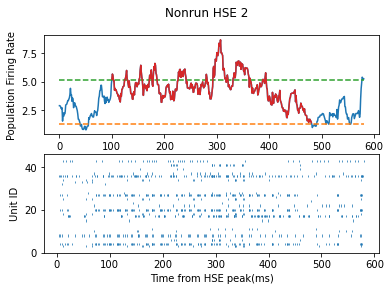

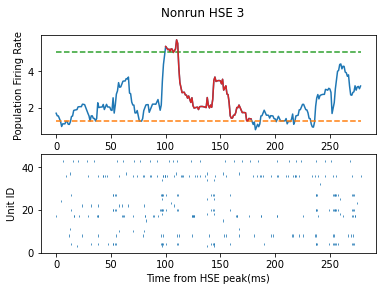

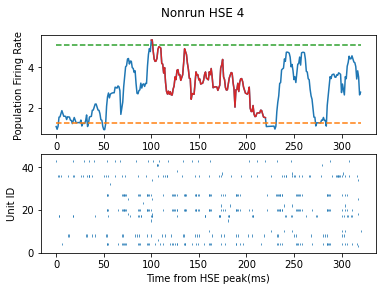

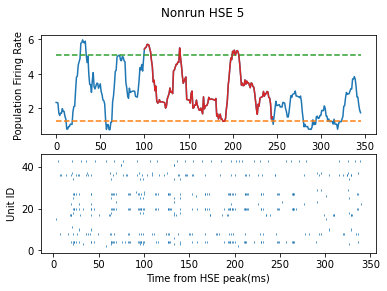

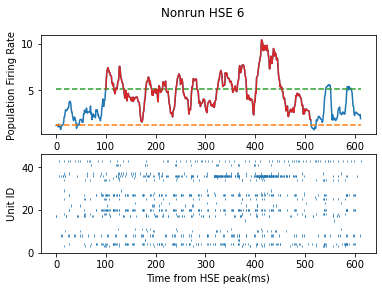

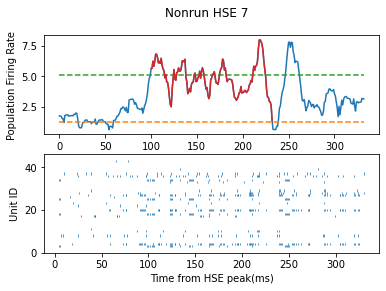

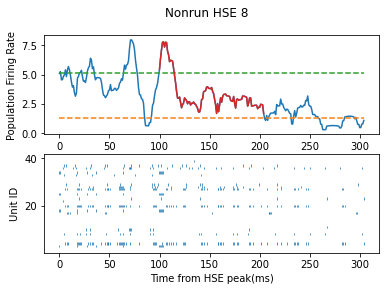

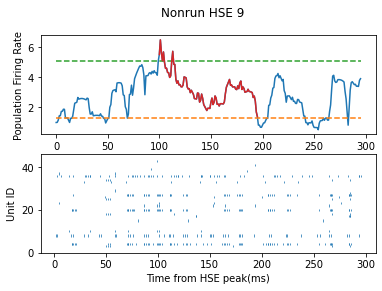

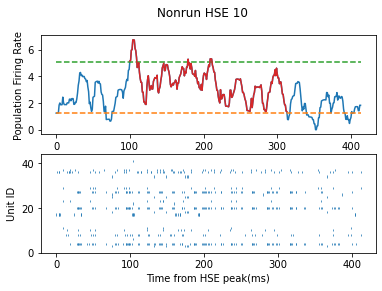

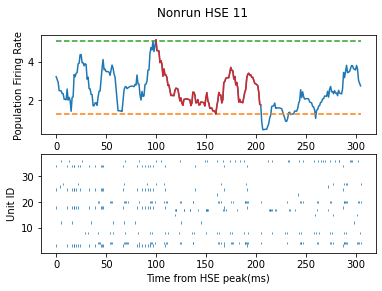

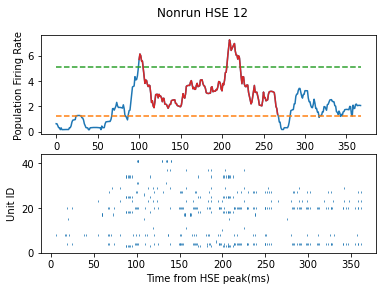

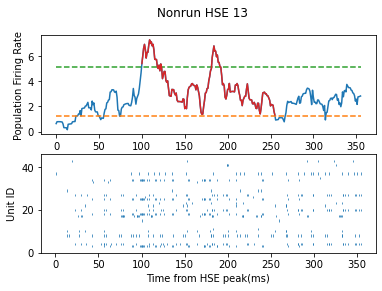

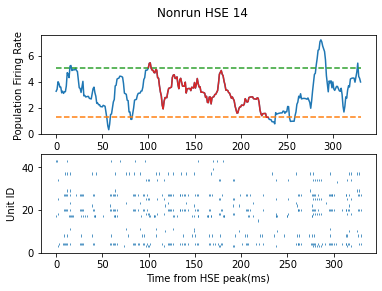

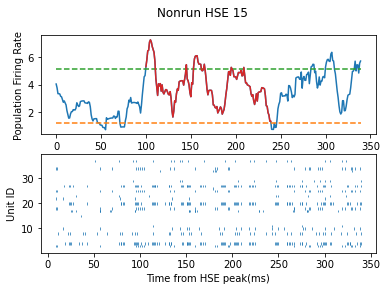

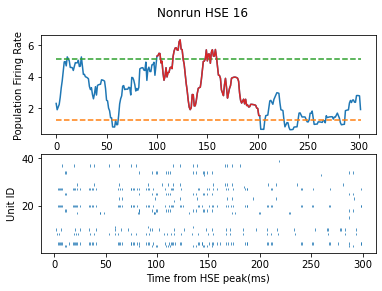

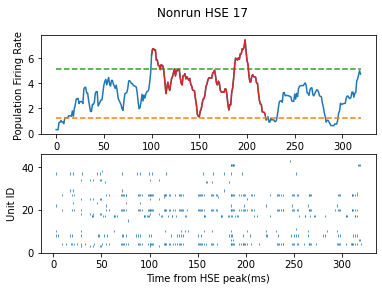

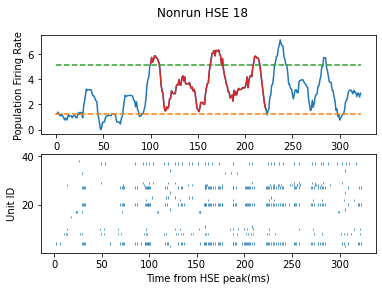

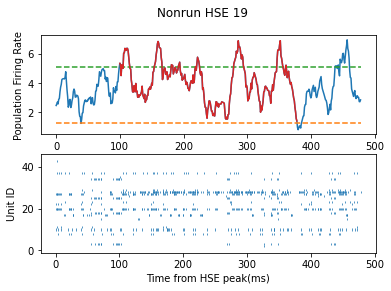

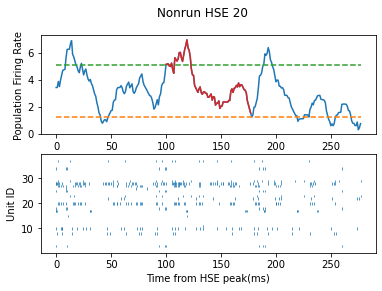

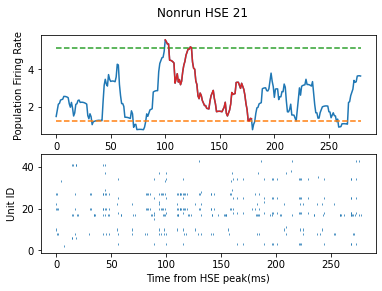

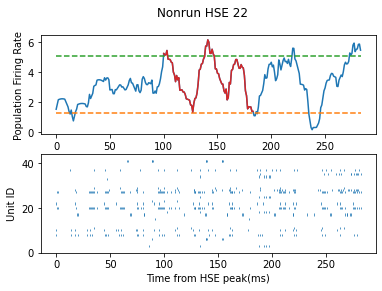

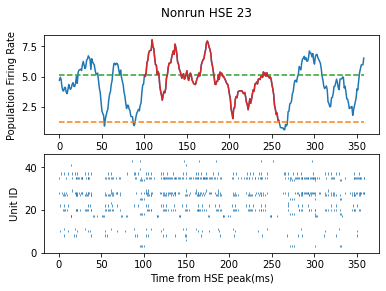

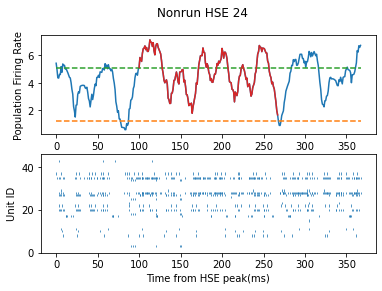

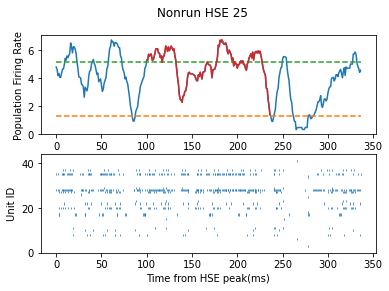

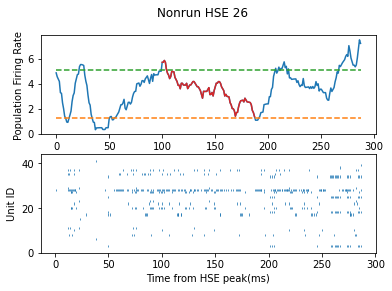

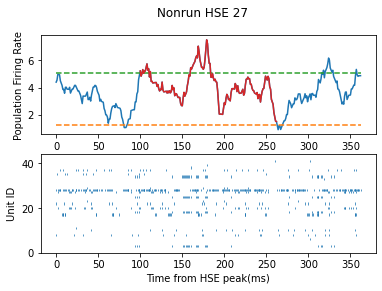

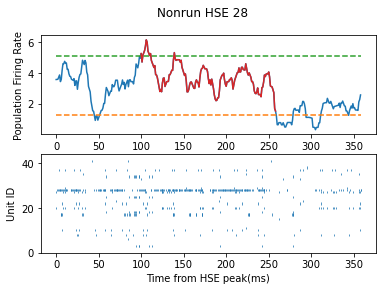

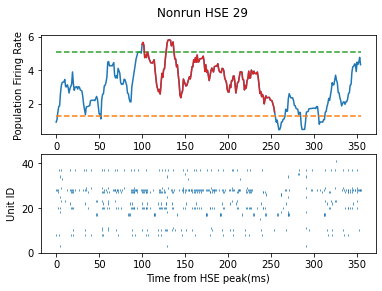

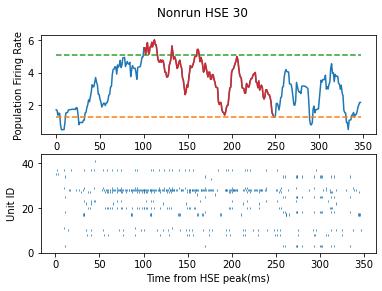

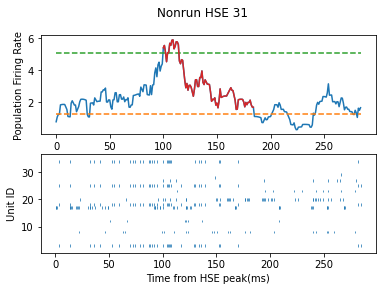

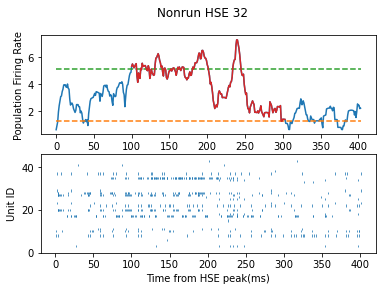

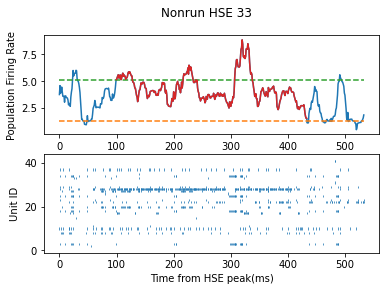

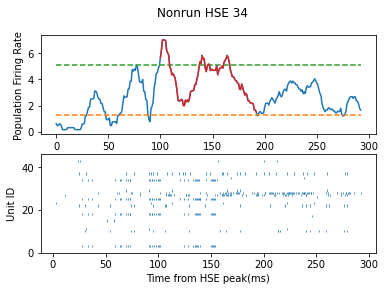

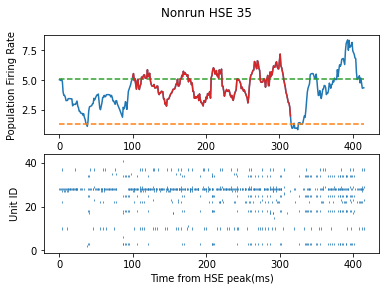

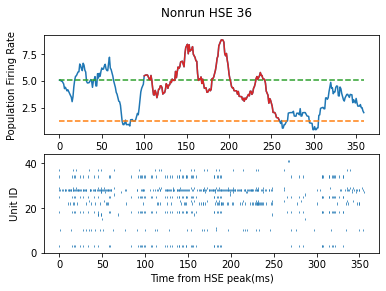

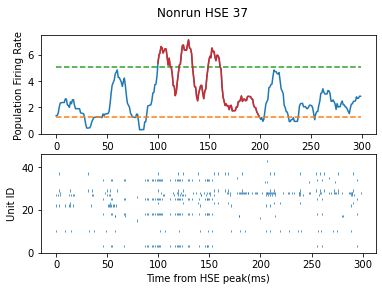

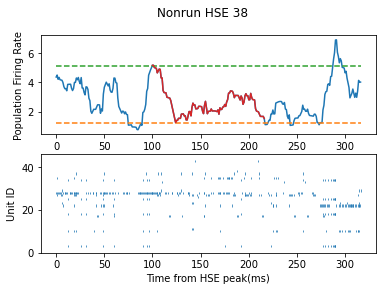

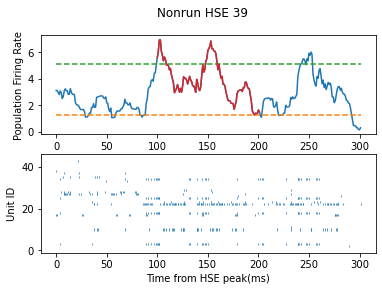

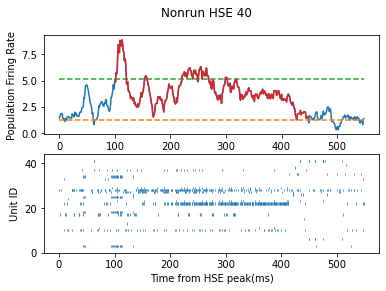

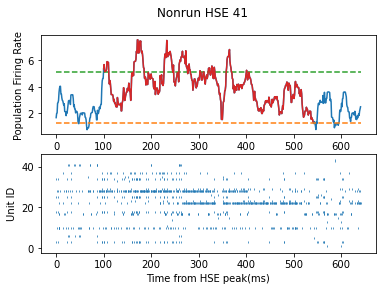

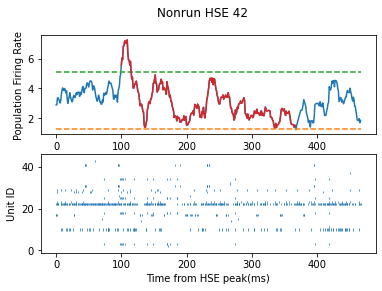

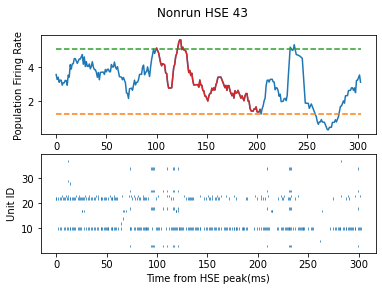

In [135]:
for k in range(len(nonrun_HSE_events_time)):
    t_begin, t_end = nonrun_HSE_events_time[k]
    plt.subplot(2,1,1)
    plt.plot(nonrun_syn_spike_rate[t_begin-100:t_end+100])
    plt.plot([nonrun_mean for i in range(t_end-t_begin+200)],'--')
    plt.plot([nonrun_mean+3*nonrun_SD for i in range(t_end-t_begin+200)], '--')
    plt.plot(np.arange(100, 100 + t_end - t_begin), nonrun_syn_spike_rate[t_begin: t_end])
    plt.ylabel('Population Firing Rate')
 
    plt.subplot(2,1,2)
    for i in range(cell_num):
        ys = []
        for j in range(t_begin-100, t_end+100):
            if cell_nonrun[i][j] != 0:
                num = int(cell_nonrun[i][j]/100)
                for s in range(num):
                    ys.append(j-(t_begin-100))
        plt.eventplot(ys, orientation='horizontal', lineoffsets=i+1, linewidth=0.75)
    plt.xlabel('Time from HSE peak(ms)')
    plt.ylabel('Unit ID')
    plt.suptitle('Nonrun HSE '+str(k+1))
    plt.show()

## in pre trial periods

In [117]:
%%time
pre_mean, pre_SD, pre_syn_spike_rate, pre_HSE_events_time = HSE_detection(pre_cell_trains, ori_bins=100)

Wall time: 1.93 s


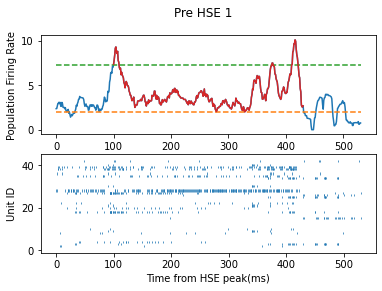

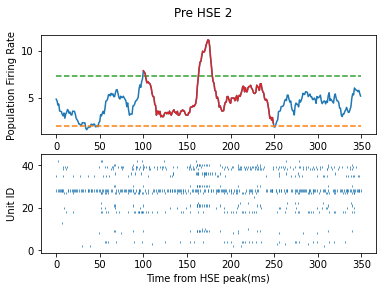

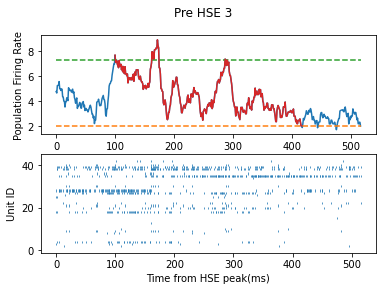

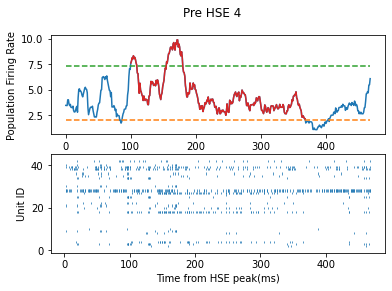

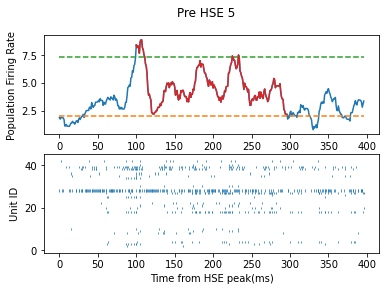

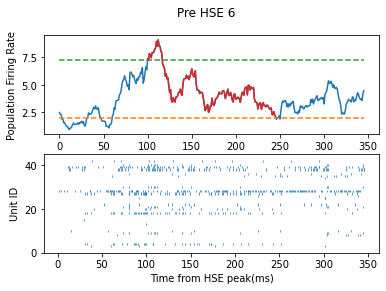

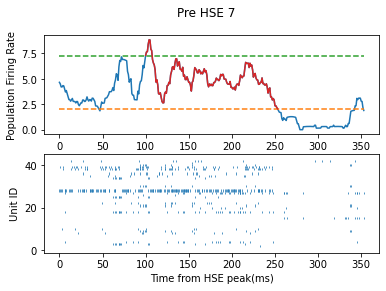

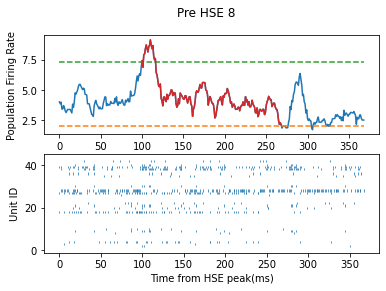

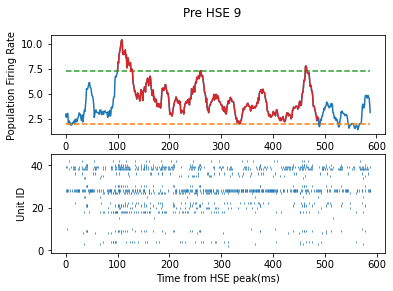

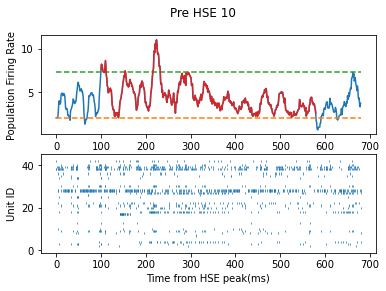

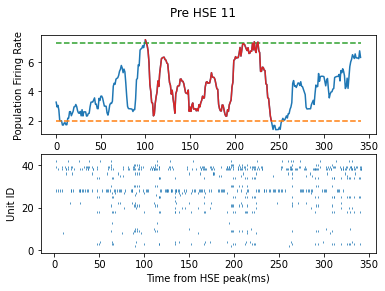

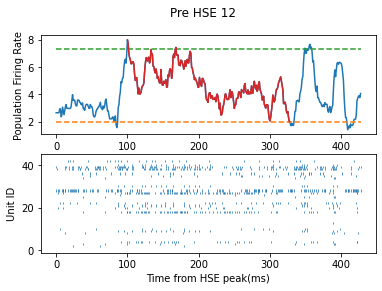

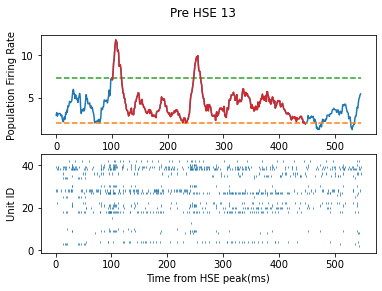

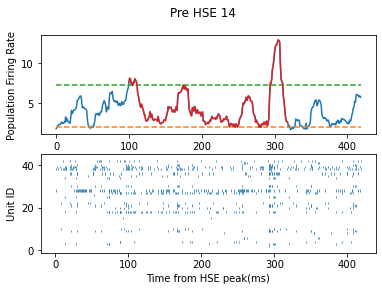

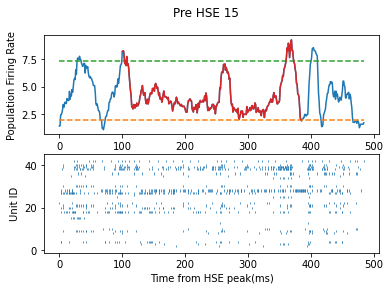

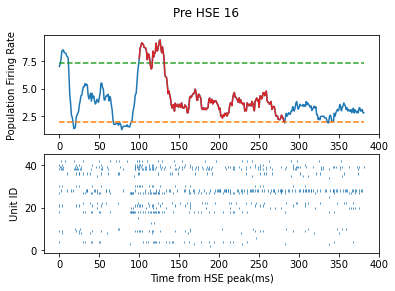

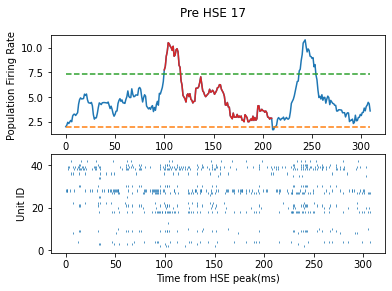

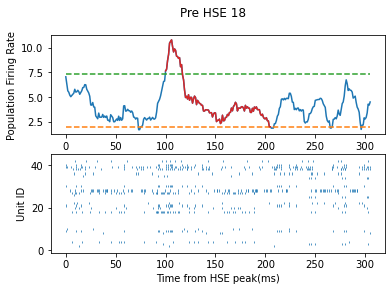

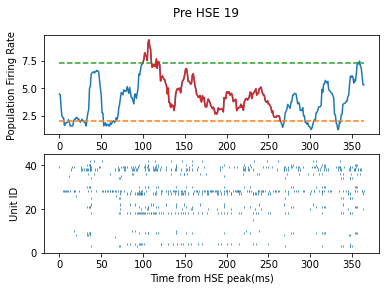

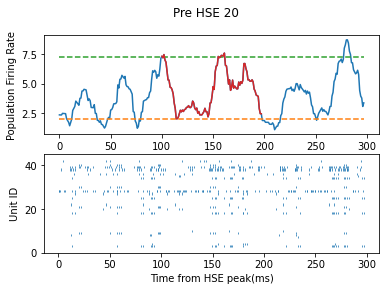

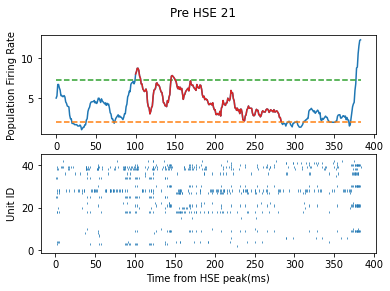

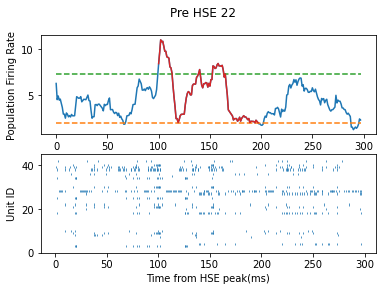

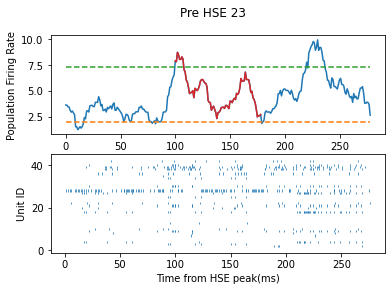

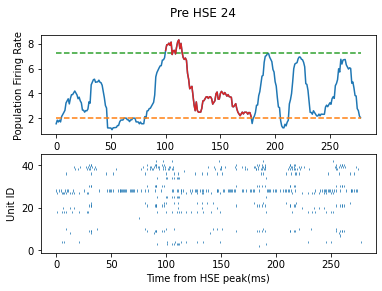

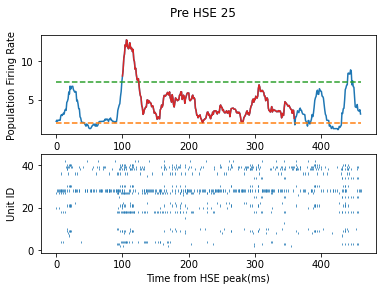

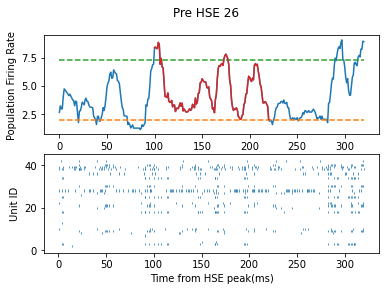

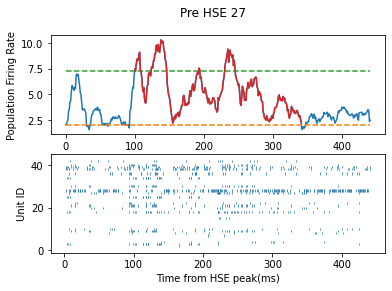

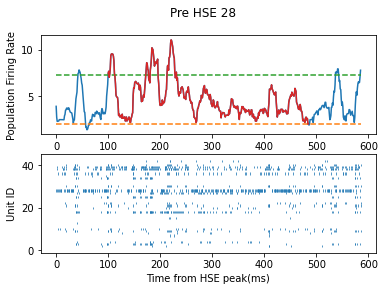

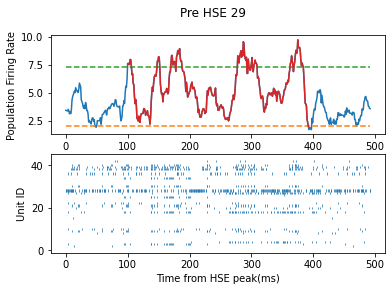

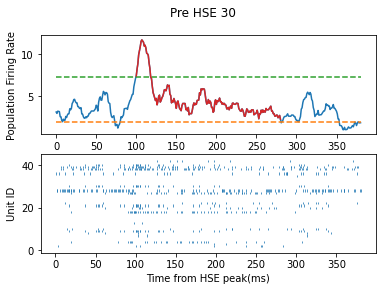

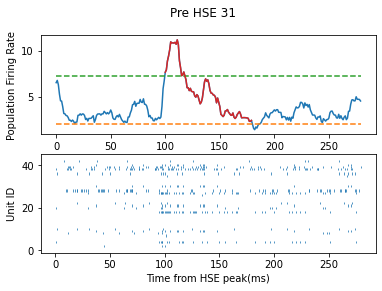

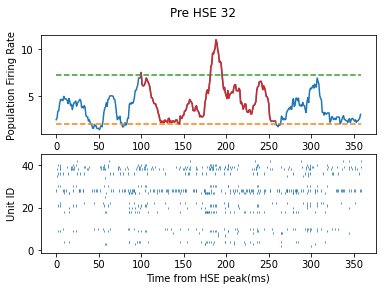

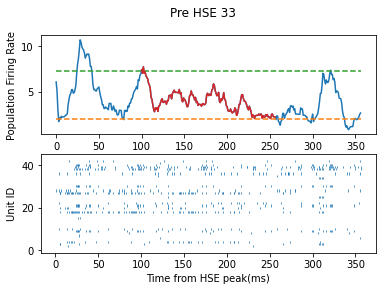

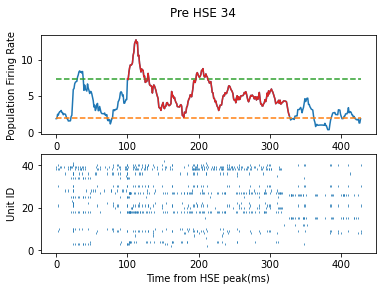

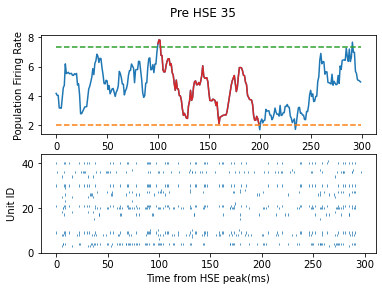

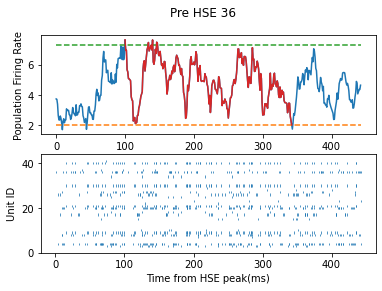

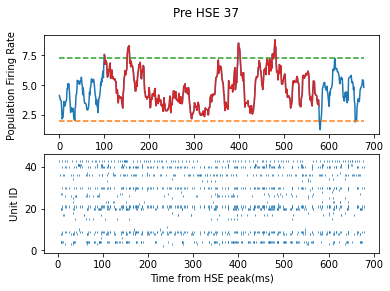

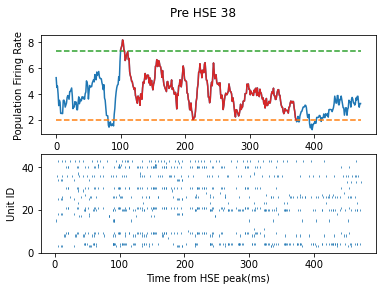

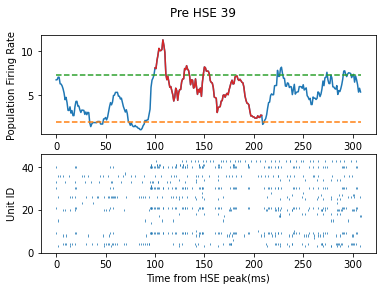

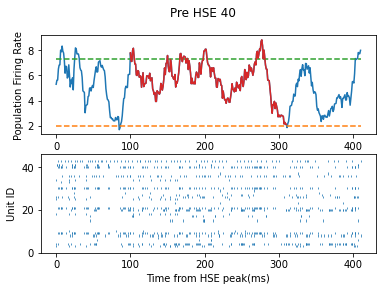

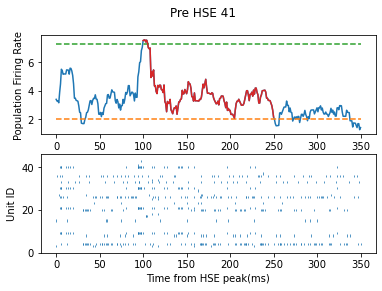

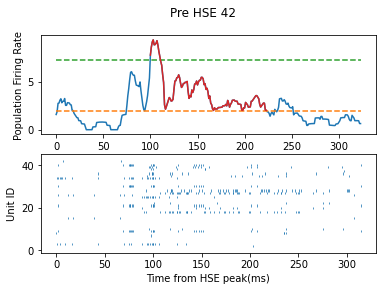

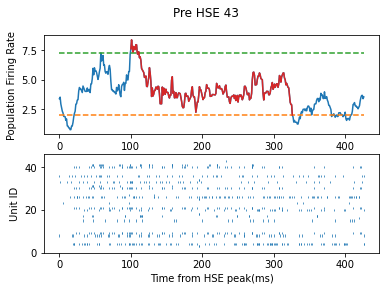

In [134]:
for k in range(len(pre_HSE_events_time)):
    t_begin, t_end = pre_HSE_events_time[k]
    plt.subplot(2,1,1)
    plt.plot(pre_syn_spike_rate[t_begin-100:t_end+100])
    plt.plot([pre_mean for i in range(t_end-t_begin+200)],'--')
    plt.plot([pre_mean+3*pre_SD for i in range(t_end-t_begin+200)], '--')
    plt.plot(np.arange(100, 100 + t_end - t_begin), pre_syn_spike_rate[t_begin: t_end])
    plt.ylabel('Population Firing Rate')
 
    plt.subplot(2,1,2)
    for i in range(cell_num):
        ys = []
        for j in range(t_begin-100, t_end+100):
            if pre_cell_trains[i][j] != 0:
                num = int(pre_cell_trains[i][j]/100)
                for s in range(num):
                    ys.append(j-(t_begin - 100))
        plt.eventplot(ys, orientation='horizontal', lineoffsets=i+1, linewidth=0.75)
    plt.xlabel('Time from HSE peak(ms)')
    plt.ylabel('Unit ID')
    plt.suptitle('Pre HSE '+str(k+1))
    plt.show()

## in pos trial periods

In [120]:
%%time
post_mean, post_SD, post_syn_spike_rate, post_HSE_events_time = HSE_detection(post_cell_trains, ori_bins=100)

Wall time: 1.79 s


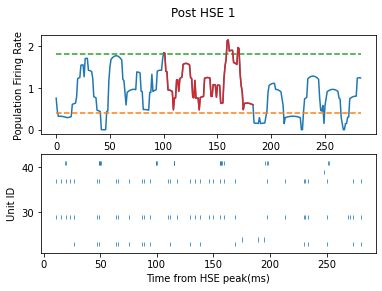

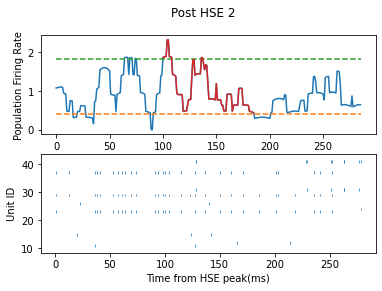

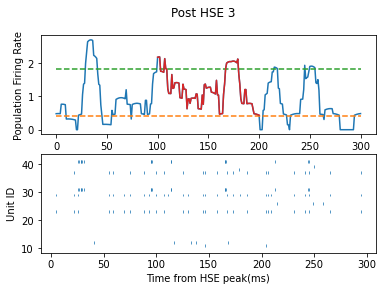

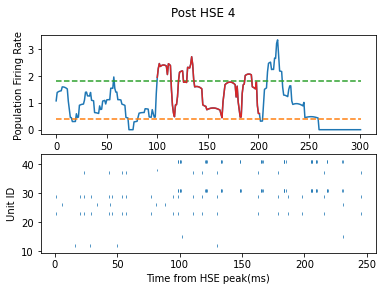

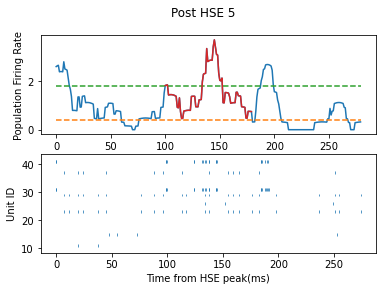

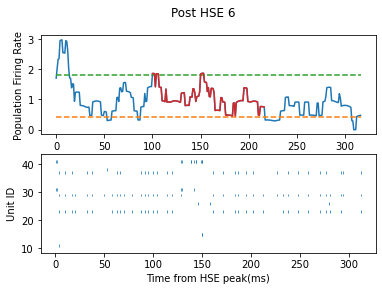

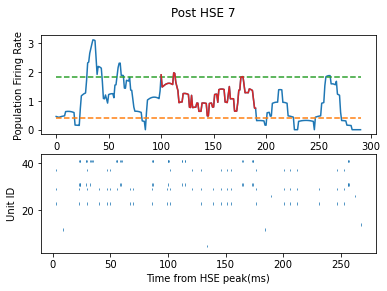

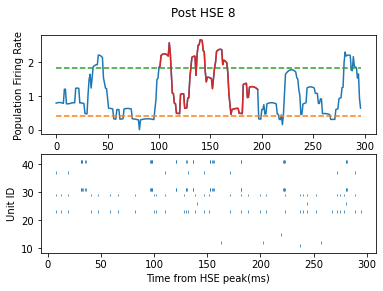

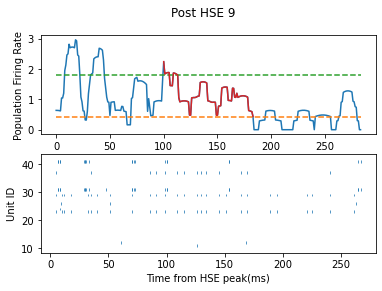

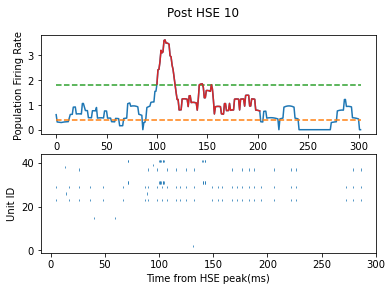

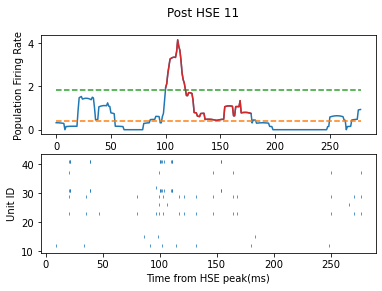

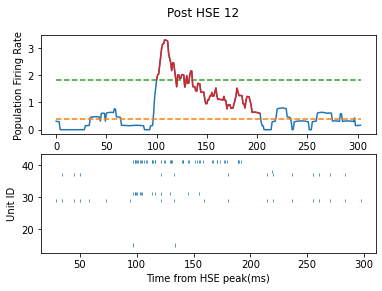

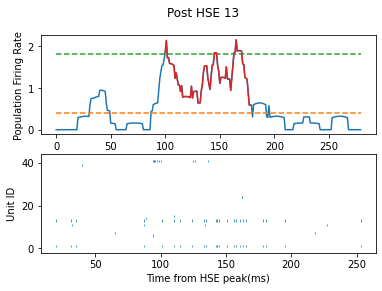

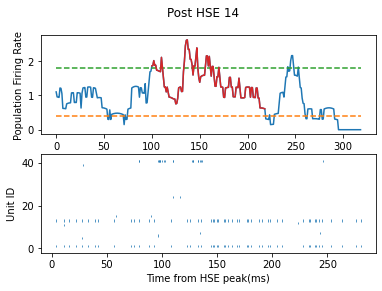

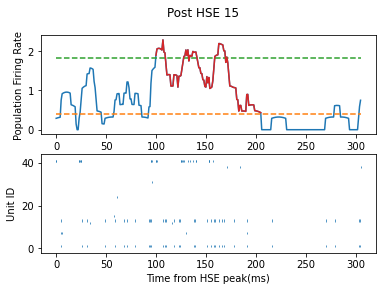

In [133]:
for k in range(len(post_HSE_events_time)):
    t_begin, t_end = post_HSE_events_time[k]
    plt.subplot(2,1,1)
    plt.plot(post_syn_spike_rate[t_begin-100:t_end+100])
    plt.plot([post_mean for i in range(t_end-t_begin+200)],'--')
    plt.plot([post_mean+3*post_SD for i in range(t_end-t_begin+200)], '--')
    plt.plot(np.arange(100, 100 + t_end - t_begin), post_syn_spike_rate[t_begin: t_end])
    plt.ylabel('Population Firing Rate')
 
    plt.subplot(2,1,2)
    for i in range(cell_num):
        ys = []
        for j in range(t_begin-100, t_end+100):
            if post_cell_trains[i][j] != 0:
                num = int(post_cell_trains[i][j]/100)
                for s in range(num):
                    ys.append(j - (t_begin - 100))
        plt.eventplot(ys, orientation='horizontal', lineoffsets=i+1, linewidth=0.75)
    plt.xlabel('Time from HSE peak(ms)')
    plt.ylabel('Unit ID')
    plt.suptitle('Post HSE '+str(k+1))
    plt.show()

# use decoder to predict positions in HES and plot

exclude cells that are not in the tuning curve

In [138]:
cell_nonrun_re = np.zeros((cell_run_num, cell_nonrun.shape[1]))
pre_cell_trains_re = np.zeros((cell_run_num, pre_cell_trains.shape[1]))
post_cell_trains_re = np.zeros((cell_run_num, post_cell_trains.shape[1]))
j = 0
for i in range(cell_num):
    if i in [8, 20, 29, 39]:
        continue
    cell_nonrun_re[j, :] = cell_nonrun[i, :]
    pre_cell_trains_re[j, :] = pre_cell_trains[i, :]
    post_cell_trains_re[j, :] = post_cell_trains[i, :]
    j += 1

## predict positions in nonrun HSE

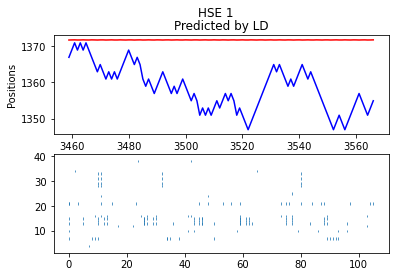

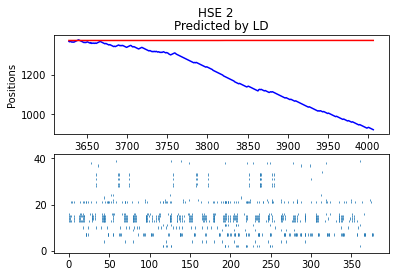

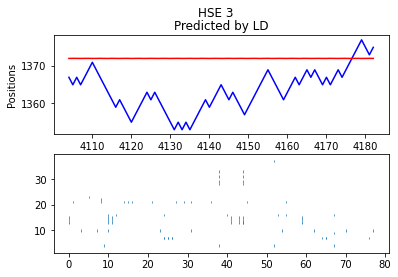

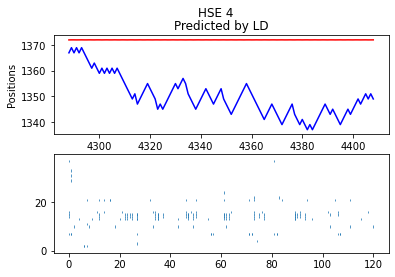

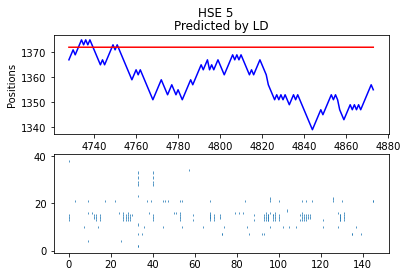

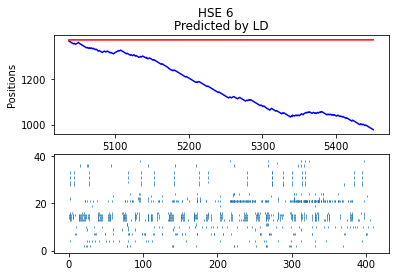

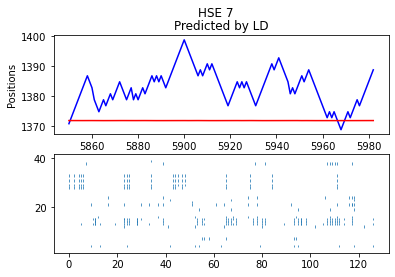

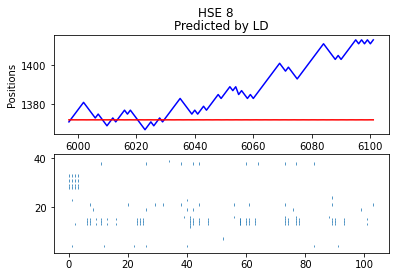

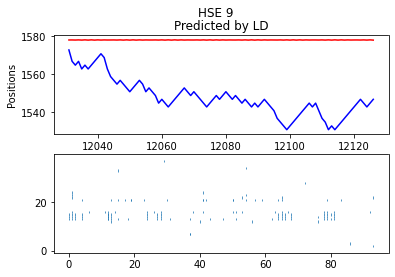

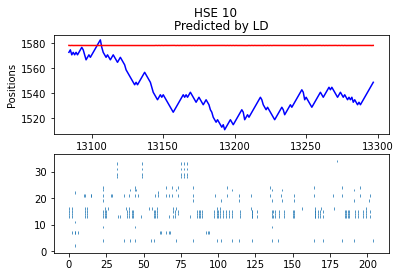

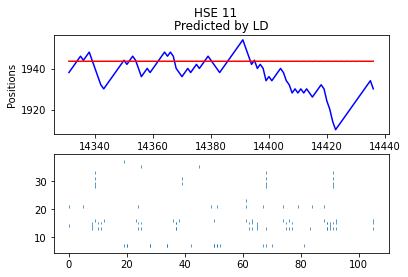

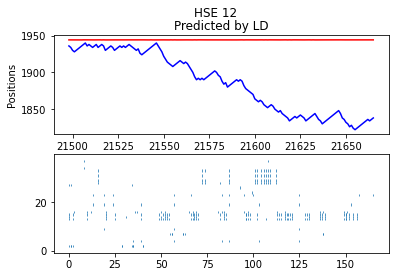

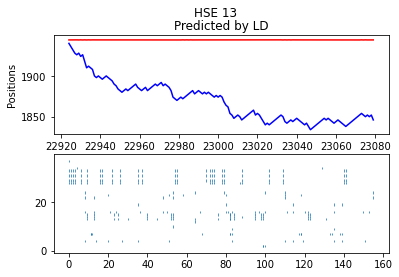

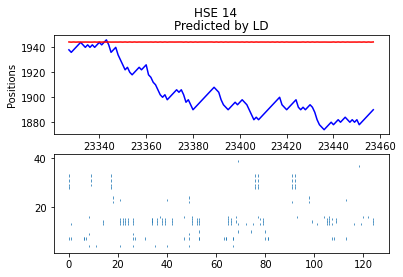

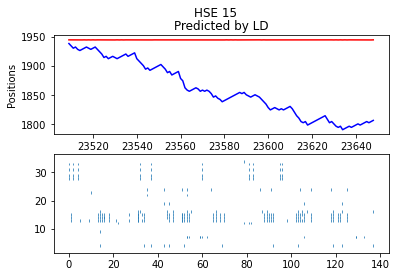

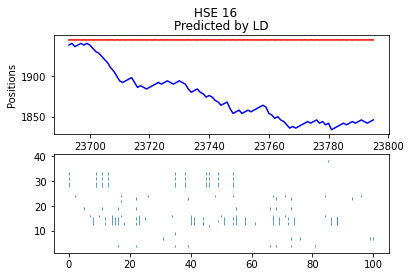

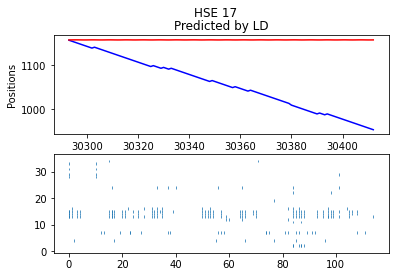

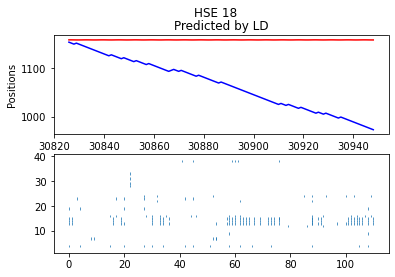

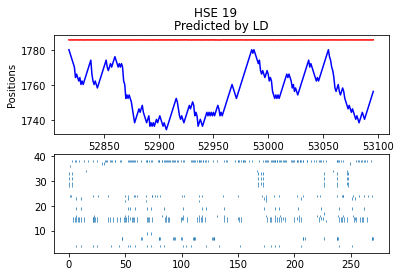

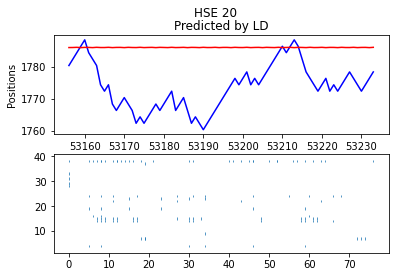

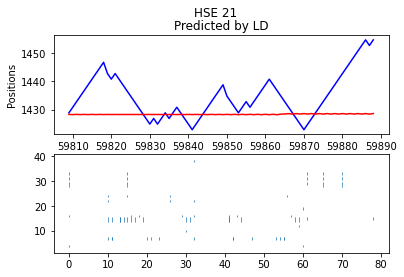

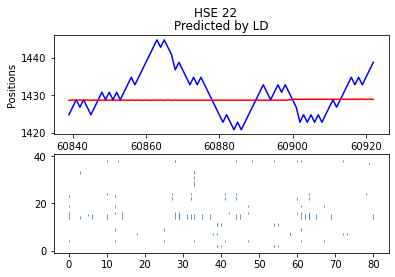

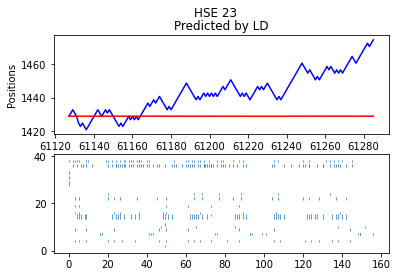

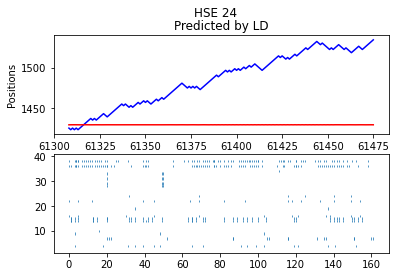

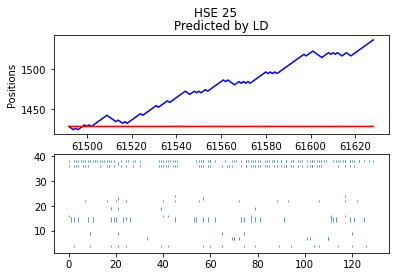

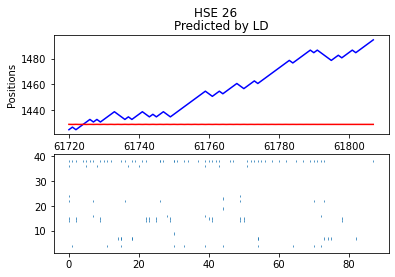

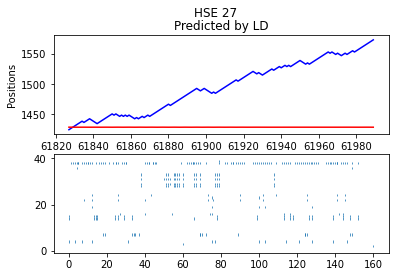

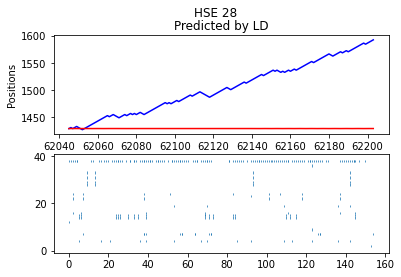

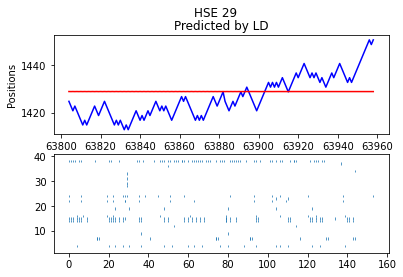

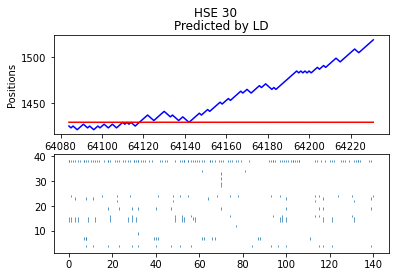

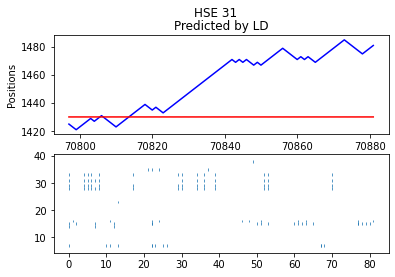

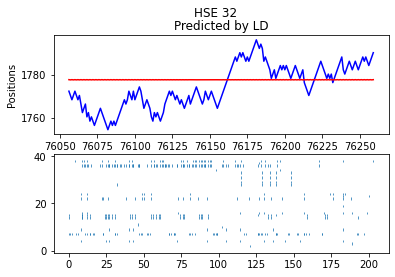

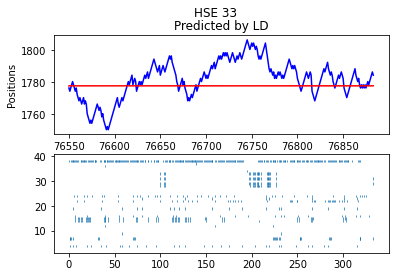

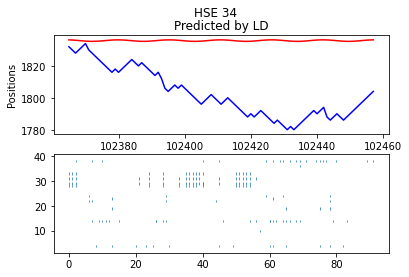

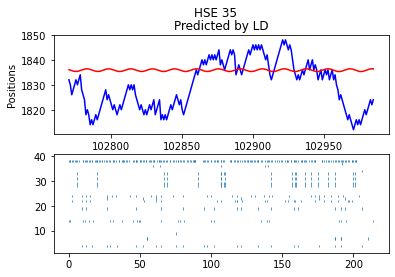

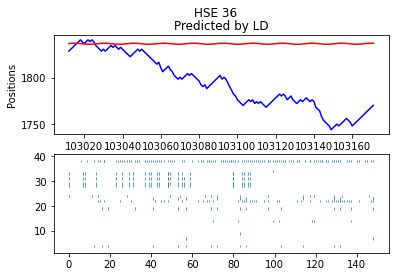

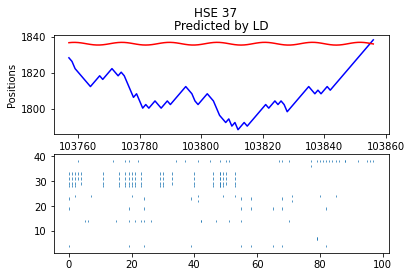

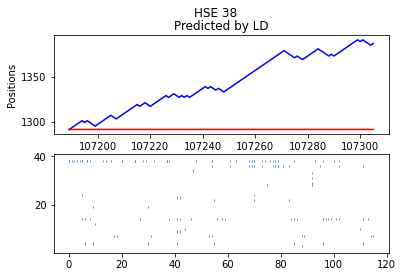

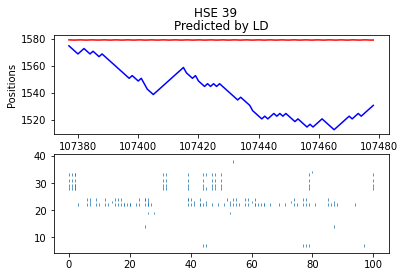

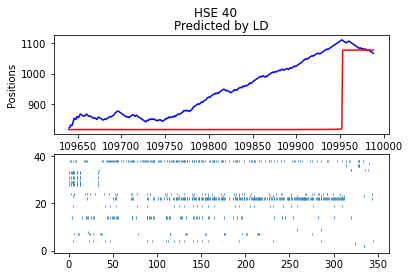

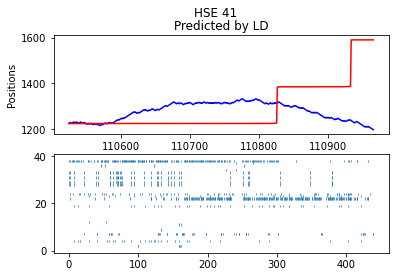

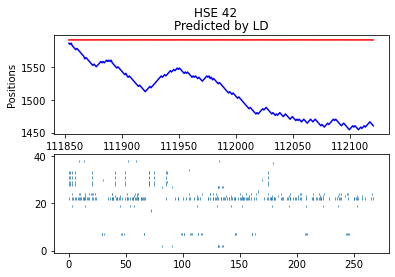

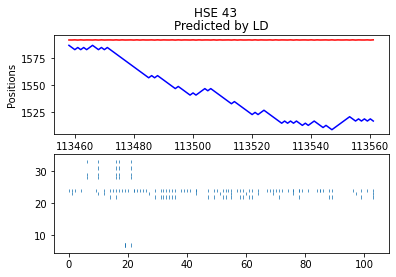

In [144]:
dt = 1 / bins
LD = Loc_trainsitionDecoder(dt, track_len, track_sample_len, track_Bins, cell_run_num, tuning, loc_prob=loc_prob)
# PD = Position_basedDecoder(dt, track_len, track_sample_len, track_Bins, cell_run_num, tuning, loc_possi=loc_possi)
for i in range(len(nonrun_HSE_events_time)):
    t_begin, t_end = nonrun_HSE_events_time[i]
    pos_predict = LD.predict(cell_nonrun_re[:, t_begin:t_end], (pos_nonrun[t_begin]-600) / track_sample_len)
    plt.subplot(2,1,1)
    plt.plot(np.arange(t_begin, t_end), pos_predict+600, label='LD', color='blue')
    plt.plot(np.arange(t_begin, t_end), pos_nonrun[t_begin: t_end], label='Real', color='red')
    plt.ylabel('Positions')
    plt.title('Predicted by LD')
    plt.suptitle('HSE '+str(i+1))
    
    plt.subplot(2,1,2)
    for i in range(cell_run_num):
        ys = []
        k = sorted_ID[i]
        for j in range(t_begin, t_end):
            if cell_nonrun_re[k][j] != 0:
                num = int(cell_nonrun_re[k][j]/100)
                for s in range(num):
                    ys.append(j-t_begin)
        plt.eventplot(ys, orientation='horizontal', lineoffsets=i+1, linewidth=0.75)        
    plt.show()

## predict locations in pre HSE

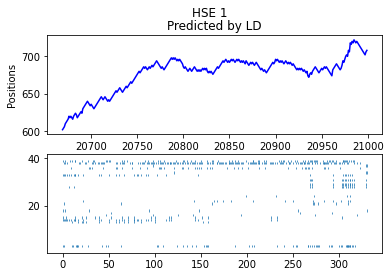

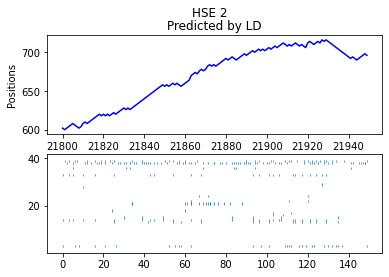

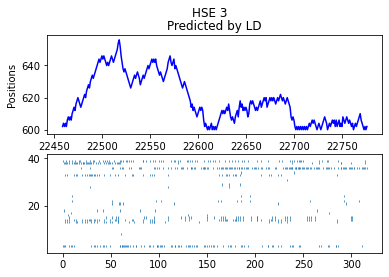

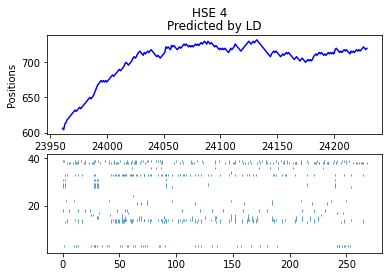

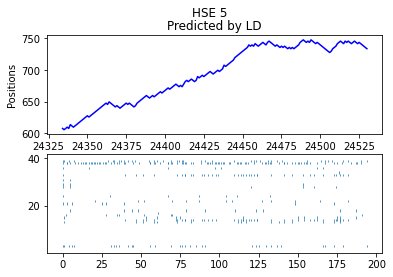

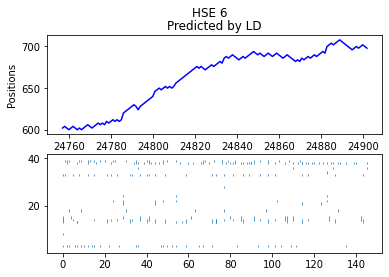

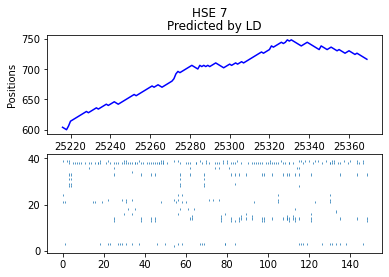

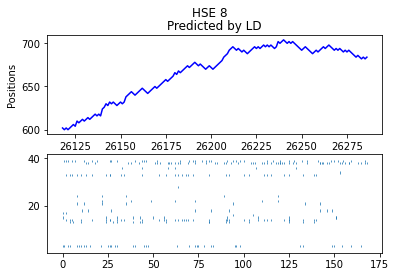

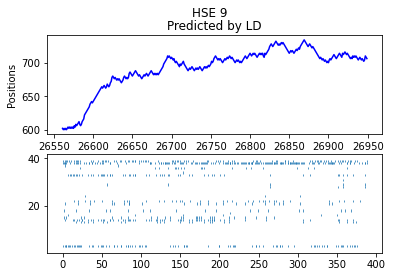

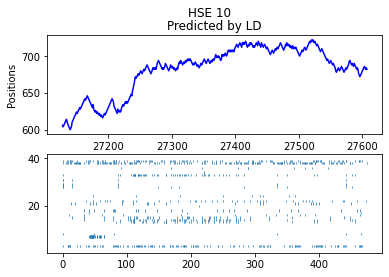

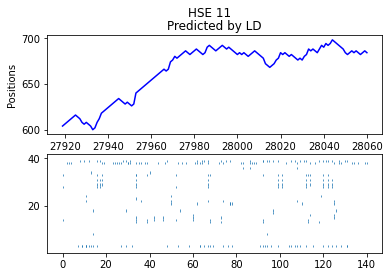

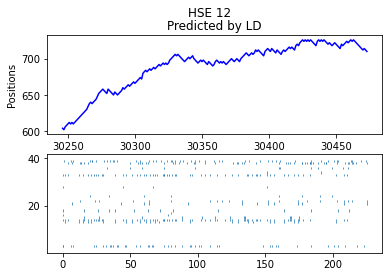

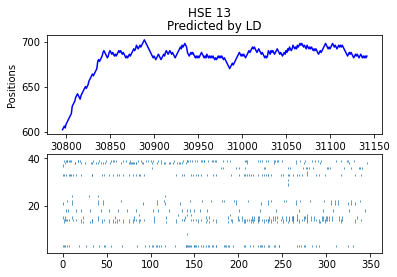

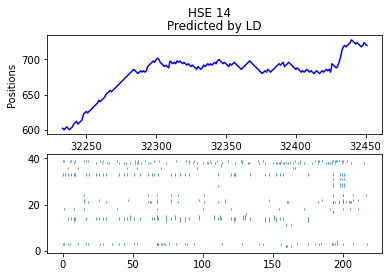

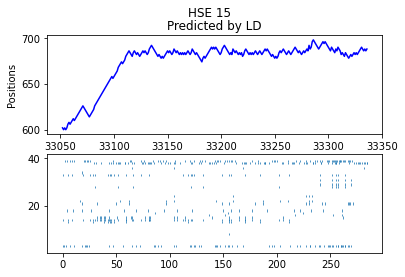

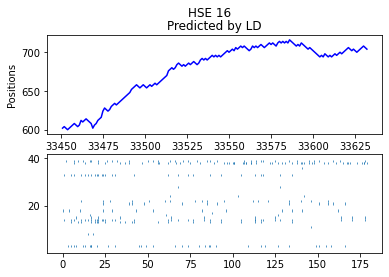

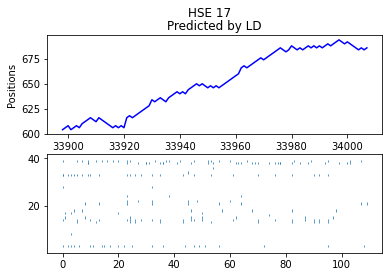

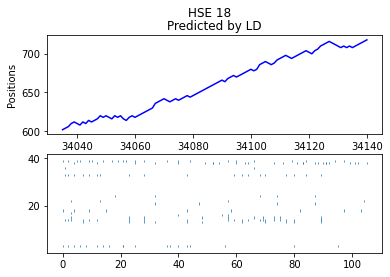

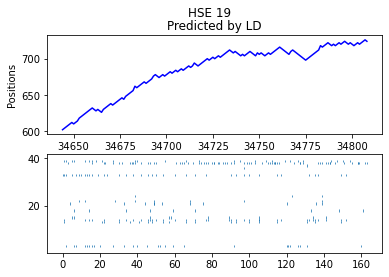

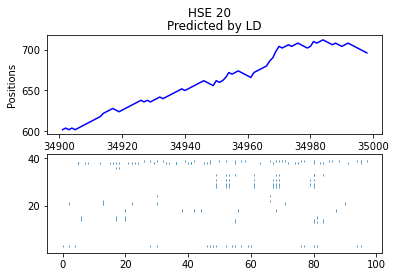

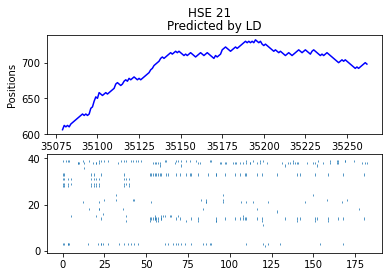

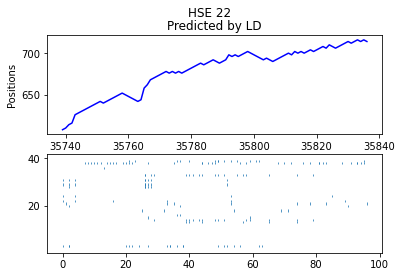

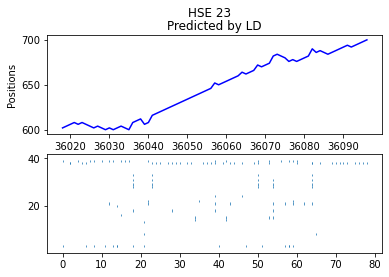

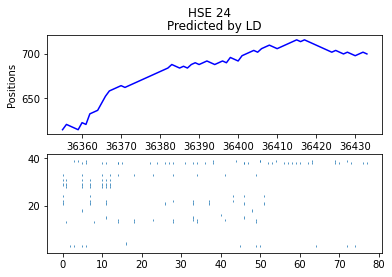

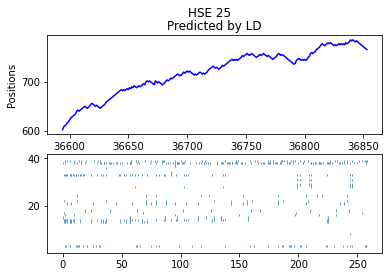

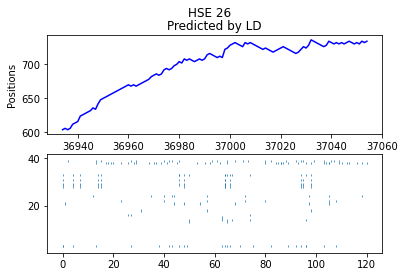

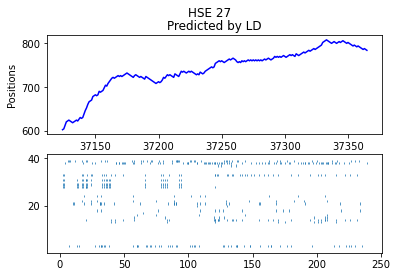

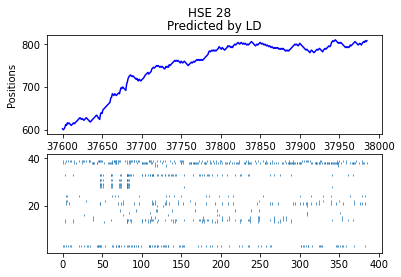

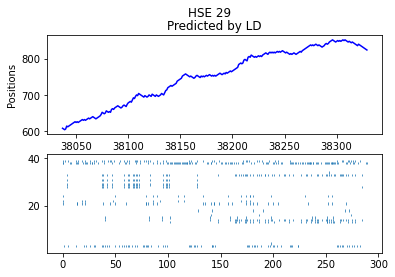

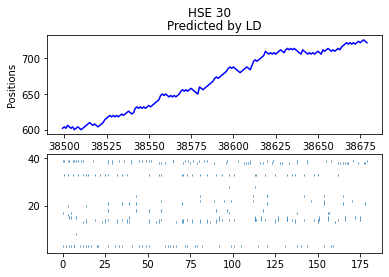

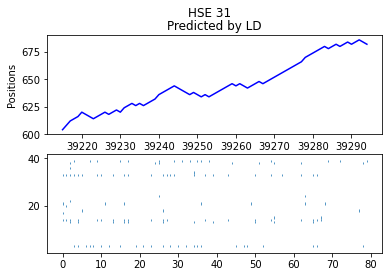

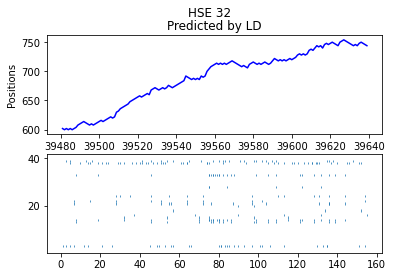

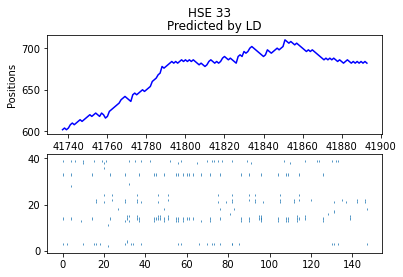

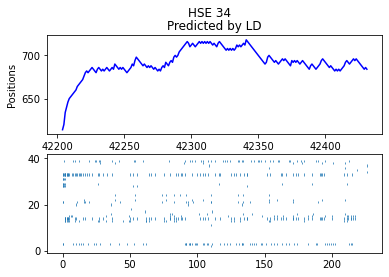

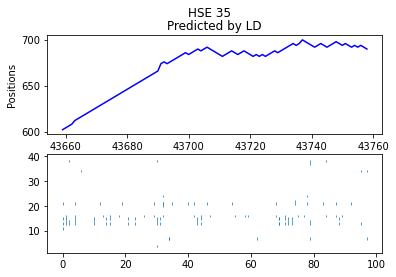

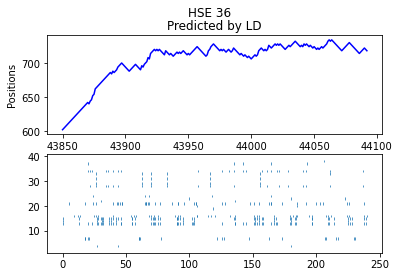

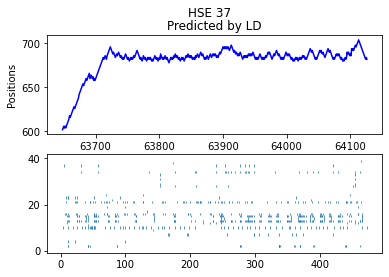

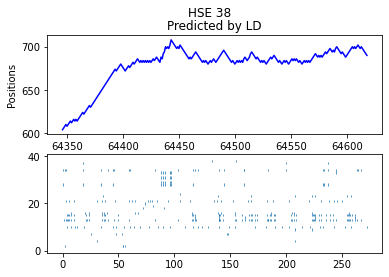

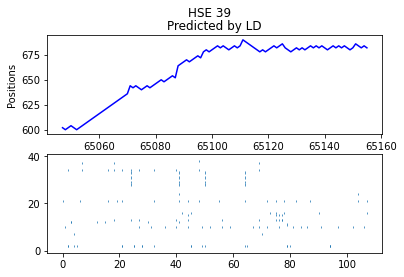

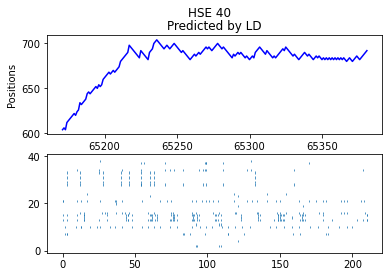

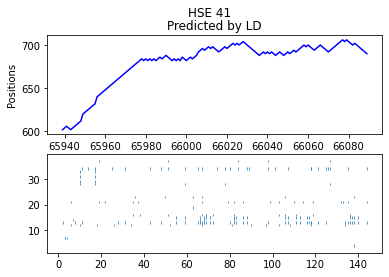

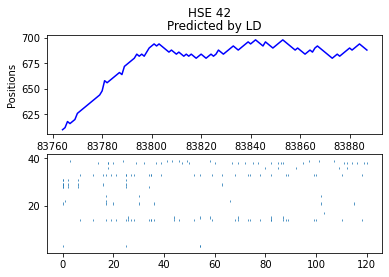

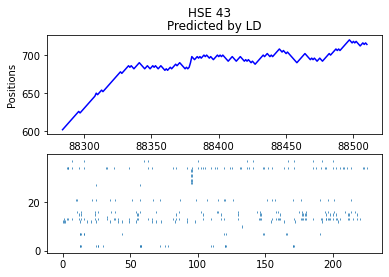

In [143]:
dt = 1 / bins
LD = Loc_trainsitionDecoder(dt, track_len, track_sample_len, track_Bins, cell_run_num, tuning, loc_prob=loc_prob)
# PD = Position_basedDecoder(dt, track_len, track_sample_len, track_Bins, cell_run_num, tuning, loc_possi=loc_possi)
for i in range(len(pre_HSE_events_time)):
    t_begin, t_end = pre_HSE_events_time[i]
    pos_predict = LD.predict(pre_cell_trains_re[:, t_begin:t_end], pos=0)
    plt.subplot(2,1,1)
    plt.plot(np.arange(t_begin, t_end), pos_predict+600, label='LD', color='blue')
    plt.ylabel('Positions')
    plt.title('Predicted by LD')
    plt.suptitle('HSE '+str(i+1))

    plt.subplot(2,1,2)
    for i in range(cell_run_num):
        ys = []
        k = sorted_ID[i]
        for j in range(t_begin, t_end):
            if pre_cell_trains_re[k][j] != 0:
                num = int(pre_cell_trains_re[k][j]/100)
                for s in range(num):
                    ys.append(j-t_begin)
        plt.eventplot(ys, orientation='horizontal', lineoffsets=i+1, linewidth=0.75)        
    plt.show()

## predict locations in post HSE

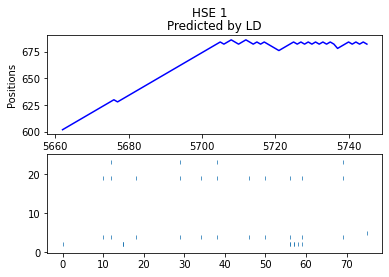

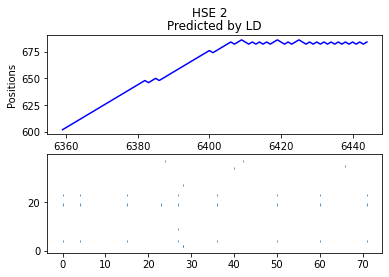

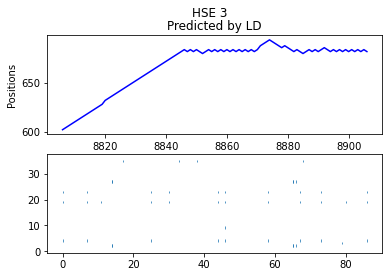

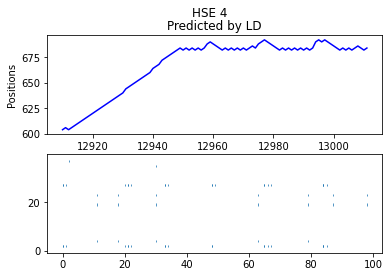

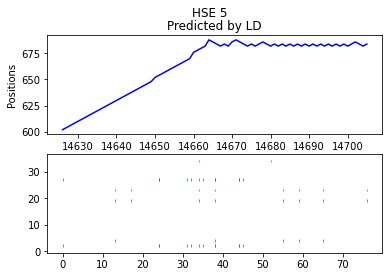

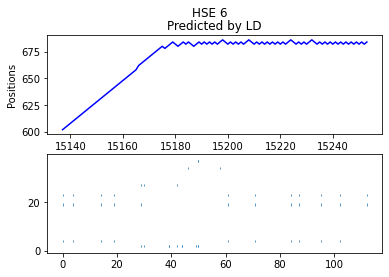

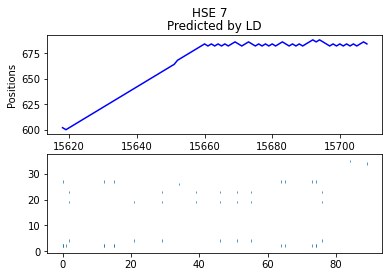

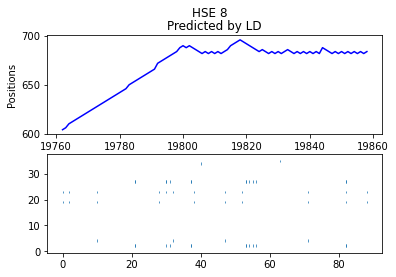

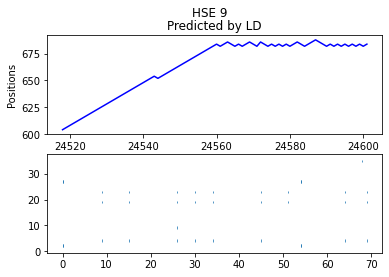

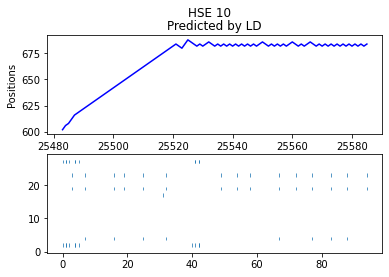

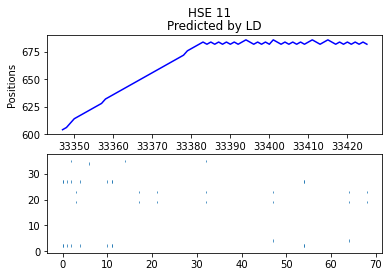

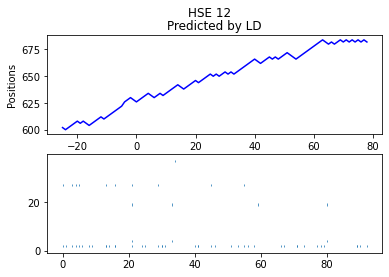

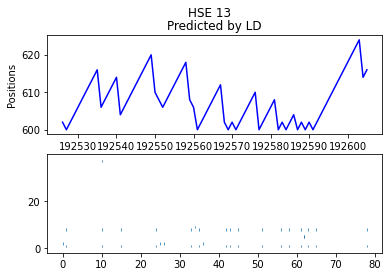

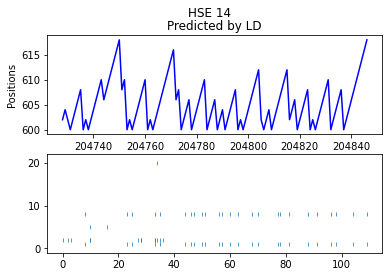

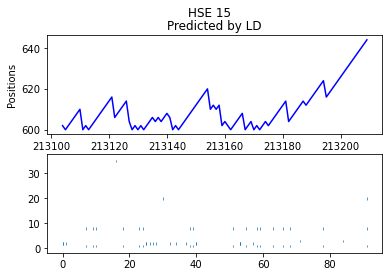

In [145]:
 dt = 1 / bins
LD = Loc_trainsitionDecoder(dt, track_len, track_sample_len, track_Bins, cell_run_num, tuning, loc_prob=loc_prob)
# PD = Position_basedDecoder(dt, track_len, track_sample_len, track_Bins, cell_run_num, tuning, loc_possi=loc_possi)
for i in range(len(post_HSE_events_time)):
    t_begin, t_end = post_HSE_events_time[i]
    pos_predict = LD.predict(post_cell_trains_re[:, t_begin:t_end], pos=0)
    plt.subplot(2,1,1)
    plt.plot(np.arange(t_begin, t_end), pos_predict+600, label='LD', color='blue')
    plt.ylabel('Positions')
    plt.title('Predicted by LD')
    plt.suptitle('HSE '+str(i+1))

    plt.subplot(2,1,2)
    for i in range(cell_run_num):
        ys = []
        k = sorted_ID[i]
        for j in range(t_begin, t_end):
            if post_cell_trains_re[k][j] != 0:
                num = int(post_cell_trains_re[k][j]/100)
                for s in range(num):
                    ys.append(j-t_begin)
        plt.eventplot(ys, orientation='horizontal', lineoffsets=i+1, linewidth=0.75)        
    plt.show()